# Классификация тем статей Ведомостей

В прошлом ноутбуке мы выкачали архив новостей Ведомостей по разным темам. В ссылку на каждую статью зашита её тема. Попробуем по тексту статьи определить её

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

### Данные

In [3]:
df = pd.read_pickle('data/vedomosti_archive.pkl')

In [4]:
df.head()

,url,topic,format,header,text,normalized
0,https://www.vedomosti.ru/business/news/2016/01...,business,news,Россия с 1 января запрещает ввоз свинины с Укр...,Россельхознадзор с 1 января вводит запрет на п...,россельхознадзор с 1 январь вводить запрет на ...
1,https://www.vedomosti.ru/politics/news/2016/01...,politics,news,Эрдоган назвал гитлеровскую Германию примером ...,Президент Турции Тайип Эрдоган в качестве прим...,президент турция тайип эрдогать в качество при...
2,https://www.vedomosti.ru/politics/news/2016/01...,politics,news,Саудовская Аравия открыла посольство в Ираке с...,Саудовская Аравия спустя 25 лет открыла в стол...,саудовский аравия спустя 25 год открыть в стол...
3,https://www.vedomosti.ru/politics/news/2016/01...,politics,news,США и их союзники нанесли более 20 авиаударов ...,США и их союзники по антитеррористической коал...,сша и они союзник по антитеррористический коал...
4,https://www.vedomosti.ru/business/news/2016/01...,business,news,Экспортная пошлина на нефть в России с 1 январ...,"Экспортная пошлина на нефть в России, по данны...","экспортный пошлина на нефть в россия , по данн..."


In [5]:
df.topic.value_counts()

politics      3098
business      2076
finance       1149
newspaper      863
economics      809
technology     692
realty         357
opinion        255
auto           244
lifestyle      202
management     176
library         79
Name: topic, dtype: int64

### Оставим себе задачу бинарной классификации: политика или финансы?

In [6]:
df = df[(df.topic=='politics')|(df.topic=='finance')]
df.index = range(len(df))

In [7]:
df["topic"] = df.topic.apply(lambda x: 1 if x=='politics' else 0)

In [8]:
df.topic.value_counts()

1    3098
0    1149
Name: topic, dtype: int64

Уберём все токены, которые не являются словами, при этом все числа заменив на "num"

In [9]:
df["normalized_words"] = df.normalized.apply(lambda x: ' '.join([w if w.isalpha() else 'num' for w in x.split() if w.isalpha() or w.isdigit()]))

### Векторизуем тексты

Здесь мы немного забежим вперёд и используем векторизацию текста в мешок слов ([bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model))

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
vectorizer = CountVectorizer(max_features=5000)

In [12]:
%%time
X = vectorizer.fit_transform(df.normalized_words).toarray()

CPU times: user 668 ms, sys: 50.5 ms, total: 718 ms
Wall time: 720 ms


In [13]:
y = df.topic

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [16]:
y_train.value_counts()

1    2485
0     912
Name: topic, dtype: int64

### Обучим обычным деревом

In [17]:
from sklearn.tree import DecisionTreeClassifier

но не забудем валидацию

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
depths = np.arange(2, 15, 2)
#min_samples_leafs = np.arange(1, 10, 2)
grid = {'max_depth': depths}#, 'min_samples_leaf': min_samples_leafs}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='f1', cv=10)

In [20]:
%%time
gridsearch.fit(X_train, y_train)

CPU times: user 1min 22s, sys: 3.62 s, total: 1min 25s
Wall time: 1min 26s


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [21]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)[:10]

/Users/kuznetsovn/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.96770, std: 0.00629, params: {'max_depth': 10},
 mean: 0.96721, std: 0.00715, params: {'max_depth': 12},
 mean: 0.96643, std: 0.00527, params: {'max_depth': 8},
 mean: 0.96642, std: 0.00674, params: {'max_depth': 6},
 mean: 0.96602, std: 0.00609, params: {'max_depth': 14},
 mean: 0.95711, std: 0.01011, params: {'max_depth': 4},
 mean: 0.93424, std: 0.01119, params: {'max_depth': 2}]

/Users/kuznetsovn/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


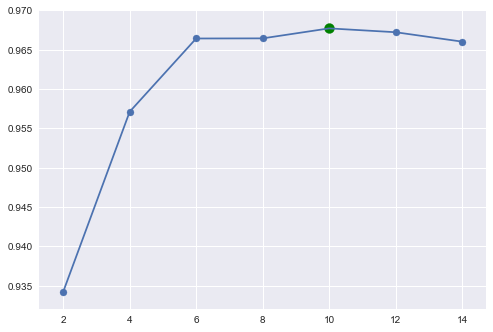

In [22]:
scores = [x.mean_validation_score for x in gridsearch.grid_scores_]# if x.parameters['min_samples_leaf']==1]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmax(scores)
plt.scatter(depths[best_point], scores[best_point], c='g', s=100)

Итак, кросс-валидация помогла нам выбрать глубину дерева равной 10

Сделаем предсказание для тестовой выборки

In [23]:
clf = DecisionTreeClassifier(max_depth=10)#, min_samples_leaf=10)

In [24]:
%%time
clf.fit(X_train, y_train)

CPU times: user 1.57 s, sys: 21.6 ms, total: 1.59 s
Wall time: 1.59 s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [25]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

### Оценим качество

In [26]:
from sklearn import metrics

In [27]:
metrics.accuracy_score(y_test, y_pred)

0.95294117647058818

In [28]:
metrics.precision_score(y_test, y_pred)

0.95548489666136727

In [29]:
metrics.recall_score(y_test, y_pred)

0.9804241435562806

In [30]:
metrics.f1_score(y_test, y_pred)

0.96779388083735907

In [31]:
metrics.roc_auc_score(y_test, y_pred_proba[:,1])

0.90707663080512935

### Посмотрим на дерево решений

http://www.webgraphviz.com

In [32]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [33]:
get_tree_dot_view(clf, vectorizer.get_feature_names(), ['finance','politics'])

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="банк <= 0.5\ngini = 0.3928\nsamples = 3397\nvalue = [912, 2485]\nclass = politics", fillcolor="#399de5a1"] ;
1 [label="нефть <= 0.5\ngini = 0.2653\nsamples = 2922\nvalue = [460, 2462]\nclass = politics", fillcolor="#399de5cf"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="цб <= 0.5\ngini = 0.1867\nsamples = 2716\nvalue = [283, 2433]\nclass = politics", fillcolor="#399de5e1"] ;
1 -> 2 ;
3 [label="банка <= 0.5\ngini = 0.1396\nsamples = 2623\nvalue = [198, 2425]\nclass = politics", fillcolor="#399de5ea"] ;
2 -> 3 ;
4 [label="биржа <= 0.5\ngini = 0.1029\nsamples = 2535\nvalue = [138, 2397]\nclass = politics", fillcolor="#399de5f0"] ;
3 -> 4 ;
5 [label="прогнозный <= 1.5\ngini = 0.0812\nsamples = 2500\nvalue = [106, 2394]\nclass = politics", fillcolor="#399de5f4"] ;
4 -> 5 ;
6 [label="рынок <= 0.5\ngini = 0.064\nsamples = 2476\nvalue = [82, 2394]\nclass = politics", fillcolor="#399de5f6"] 

### Какие слова самые важные?

In [34]:
def get_top_indexes(s):
    return sorted(range(len(s)), key=lambda k: s[k], reverse=True)

In [35]:
feature_names = vectorizer.get_feature_names()

In [36]:
top_indexes = get_top_indexes(clf.feature_importances_)
top_indexes = top_indexes[:10]
top_indexes.reverse()

In [37]:
top_importances = [clf.feature_importances_[i] for i in top_indexes]
top_words = [feature_names[i] for i in top_indexes]

''

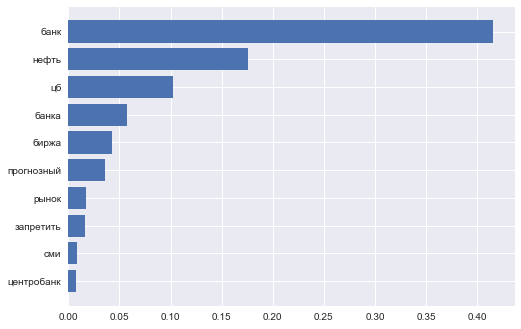

In [38]:
plt.barh(np.arange(len(top_importances)), top_importances)
plt.yticks(np.arange(len(top_words)), top_words)
''

посмотрев на дерево решений, видно, что по этим словам просто идёт отсчения из основного корпуса политических текстов в финансовые